<a href="https://colab.research.google.com/github/meesumabidi/Optiver-Realized-Volatility-Prediction.ipynb/blob/main/Optiver_Realized_Volatility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc
import glob
import os
import time
import traceback
from contextlib import contextmanager
from enum import Enum
from typing import Dict, List, Optional, Tuple

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from IPython.display import display

from joblib import delayed, Parallel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm_notebook as tqdm


%matplotlib inline

In [ ]:


DATA_DIR = '../content/drive/MyDrive/input'

# data configurations
USE_PRECOMPUTE_FEATURES = True  # Load precomputed features for train.csv from private dataset (just for speed up)

# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.185
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# for saving quota
IS_1ST_STAGE = False
SHORTCUT_NN_IN_1ST_STAGE = False  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization


@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')
    
def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

In [ ]:
!pip -q install ../content/drive/MyDrive/input/pytorchtabnet/pytorch_tabnet-2.0.1-py3-none-any.whl


In [ ]:
train = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'train.csv'))
print(train)
stock_ids = set(train['stock_id'])

        stock_id  time_id    target
0              0        5  0.004136
1              0       11  0.001445
2              0       16  0.002168
3              0       31  0.002195
4              0       62  0.001747
...          ...      ...       ...
428927       126    32751  0.003461
428928       126    32753  0.003113
428929       126    32758  0.004070
428930       126    32763  0.003357
428931       126    32767  0.002090

[428932 rows x 3 columns]


In [ ]:
class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3


def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', directory, f'stock_id={stock_id}'))


def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

def load_book(stock_id: int, block: DataBlock=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)


def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap


def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)


def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret


def make_book_feature(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))
    
    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id
    
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_trade_feature(stock_id, block = DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id
        
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_book_feature_v2(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        try:
            price_list = prices.loc[tid].values.flatten()
            price_diff = sorted(np.diff(sorted(set(price_list))))
            ticks[tid] = price_diff[0]
        except Exception:
            print_trace(f'tid={tid}')
            ticks[tid] = np.nan
        
    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    return dst


def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)

    return df


def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d

In [ ]:
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather(os.path.join(DATA_DIR, 'optiver-df2', 'features_v2.f'))
else:
    df = make_features(train, DataBlock.TRAIN)
    # v2
    df = make_features_v2(df, DataBlock.TRAIN)

df.to_feather('features_v2.f')  # save cache

test = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'test.csv'))
if len(test) == 3:
    print('is 1st stage')
    IS_1ST_STAGE = True

if IS_1ST_STAGE and MEMORY_TEST_MODE:
    print('use copy of training data as test data to immitate 2nd stage RAM usage.')
    test_df = df.iloc[:170000].copy()
    test_df['time_id'] += 32767
    test_df['row_id'] = ''
else:
    test_df = make_features(test, DataBlock.TEST)
    test_df = make_features_v2(test_df, DataBlock.TEST)

print(df.shape)
print(test_df.shape)
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)

[load feather]  16.371sec
is 1st stage
[books]  3.925sec
[trades]  2.051sec
[extra features]  0.106sec
[books(v2)]  0.056sec
(428932, 216)
(3, 216)


In [ ]:
N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst


class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())
        feature_pivot.head()

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"


class StockIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        """stock-id based nearest neighbor features"""
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"stock-id NN (name={self.name}, metric={self.metric}, p={self.p})"

In [ ]:
# the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])
df['real_price'] = 0.01 / df['tick_size']

In [ ]:
time_id_neighbors: List[Neighbors] = []
stock_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size']
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']

    if USE_PRICE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'price')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                pivot, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_m', 
                pivot, 
                p=2, 
                metric='mahalanobis',
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_price_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True)
        )

    if USE_VOL_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors('time_vol_l1', pivot, p=1)
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_vol_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True
            )
        )

    if USE_SIZE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'trade.size.sum')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_m', 
                pivot, 
                p=2, 
                metric='mahalanobis', 
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_c', 
                pivot, 
                p=2, 
                metric='canberra'
            )
        )
        
    if USE_RANDOM_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_random', 
                pivot, 
                p=2, 
                metric='random'
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_random', 
                pivot.transpose(), 
                p=2,
                metric='random')
        )


if not USE_TIME_ID_NN:
    time_id_neighbors = []
    
if not USE_STOCK_ID_NN:
    stock_id_neighbors = []

[knn fit]  243.704sec


In [ ]:
def calculate_rank_correraltion(neighbors, top_n=5):
    if not neighbors:
        return
    neighbor_indices = pd.DataFrame()
    for n in neighbors:
        neighbor_indices[n.name] = n.neighbors[:,:top_n].flatten()

    sns.heatmap(neighbor_indices.corr('kendall'), annot=True)

In [ ]:
time_ids = np.array(sorted(df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )

time-id NN (name=time_price_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,31471,26708,7864,22752,10619,11453,1205,9352
11,11,2811,29583,30798,17639,25131,23202,14857,4739,3399
16,16,5829,4275,7783,4487,7845,25439,17530,18634,19747
31,31,6367,19386,1255,12559,19472,18358,31719,6481,26475
32,32,34,4,31554,24443,5916,19164,20430,659,31077


time-id NN (name=time_price_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,31471,11453,30183,7864,26708,4091,30430,22752,9889
11,11,2811,29583,30798,14857,4739,17639,25131,23202,13745
16,16,4275,18634,5829,25439,17530,7783,4034,4487,19747
31,31,12559,17429,26475,31719,18358,6481,7897,12348,9456
32,32,34,4,5916,31554,19164,6213,659,25636,24443


time-id NN (name=time_vol_l1, metric=minkowski, p=1)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,9352,15276,13791,1205,12923,26708,2331,2136,10672
11,11,23202,30798,17639,7460,29583,11227,2811,25131,32597
16,16,9060,25179,25439,21777,15727,17530,6476,211,30791
31,31,10291,15689,18848,22824,14449,1142,6367,21148,25731
32,34,32,4,25584,26883,5235,2772,26430,2502,22014


time-id NN (name=time_size_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,23490,22752,26708,20928,13791,1350,31883,10619
11,11,29583,19417,9822,23656,4367,22828,30798,11682,10745
16,16,25439,6121,8168,31443,7845,14721,1040,20630,11497
31,31,13594,16802,20099,31719,1239,19472,3846,12559,13989
32,32,34,4,22014,6482,27822,1392,9215,24921,30803


time-id NN (name=time_size_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,26708,30183,22752,1205,10619,9352,15276,30620,2683
11,11,2811,17639,29583,25131,28020,17604,9822,4739,30798
16,16,5829,4487,6121,7783,1040,29026,7845,17530,16118
31,31,6367,12559,22519,18358,7897,19472,31522,19386,31719
32,32,34,4,15989,11985,3732,26430,3607,10523,4487


In [ ]:
stock_ids = np.array(sorted(df['stock_id'].unique()))
for neighbor in stock_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            stock_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(stock_ids, name='stock_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).loc[64]
    )
    

stock-id NN (name=stock_price_l1, metric=minkowski, p=1)


top_1      64
top_2      53
top_3      56
top_4     124
top_5      73
top_6      96
top_7      30
top_8      28
top_9      66
top_10     33
Name: 64, dtype: int64

stock-id NN (name=stock_vol_l1, metric=minkowski, p=1)


top_1      64
top_2      20
top_3      93
top_4      67
top_5      52
top_6     107
top_7      70
top_8     120
top_9     102
top_10     39
Name: 64, dtype: int64

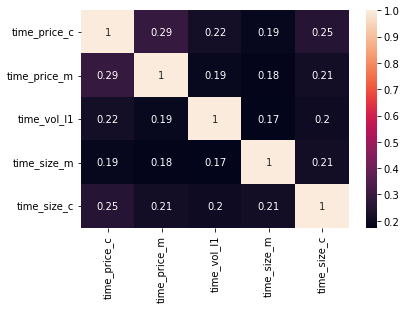

In [ ]:
calculate_rank_correraltion(time_id_neighbors)

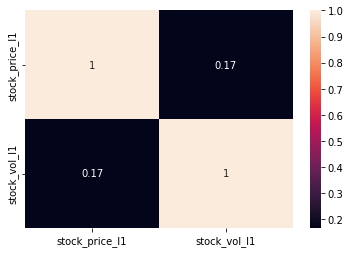

In [ ]:
calculate_rank_correraltion(stock_id_neighbors)

In [ ]:
# features with large changes over time are converted to relative ranks within time-id
if ENABLE_RANK_NORMALIZATION:
    df['trade.order_count.mean'] = df.groupby('time_id')['trade.order_count.mean'].rank()
    df['book.total_volume.sum']  = df.groupby('time_id')['book.total_volume.sum'].rank()
    df['book.total_volume.mean'] = df.groupby('time_id')['book.total_volume.mean'].rank()
    df['book.total_volume.std']  = df.groupby('time_id')['book.total_volume.std'].rank()

    df['trade.tau'] = df.groupby('time_id')['trade.tau'].rank()

    for dt in [150, 300, 450]:
        df[f'book_{dt}.total_volume.sum']  = df.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
        df[f'book_{dt}.total_volume.mean'] = df.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
        df[f'book_{dt}.total_volume.std']  = df.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()
        df[f'trade_{dt}.order_count.mean'] = df.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()

In [ ]:
def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    print(df2.shape)

    feature_cols_stock = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade_150.tau': [np.mean],
        'book.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
    }
    
    feature_cols = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'real_price': [np.max, np.mean, np.min],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
        'trade_150.tau_nn20_stock_vol_l1_mean': [np.mean],
        'trade.size.sum_nn20_stock_vol_l1_mean': [np.mean],
    }

    time_id_neigbor_sizes = [3, 5, 10, 20, 40]
    time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]
    stock_id_neighbor_sizes = [10, 20, 40]

    ndf: Optional[pd.DataFrame] = None

    def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
        if ndf is None:
            return dst
        else:
            ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
            return ndf

    # neighbor stock_id
    for feature_col in feature_cols_stock.keys():
        try:
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            if not stock_id_neighbors:
                continue

            for nn in stock_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            for agg in feature_cols_stock[feature_col]:
                for n in stock_id_neighbor_sizes:
                    try:
                        for nn in stock_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('stock-id nn')
                        pass
        except Exception:
            print_trace('stock-id nn')
            pass

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')
    ndf = None

    print(df2.shape)

    # neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_PRICE_NN_FEATURES and feature_col == 'real_price':
                continue
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            if 'volatility' in feature_col:
                time_id_ns = time_id_neigbor_sizes_vol
            else:
                time_id_ns = time_id_neigbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')

    # features further derived from nearest neighbor features
    try:
        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes:
                denominator = f"real_price_nn{sz}_time_price_c"

                df2[f'real_price_rankmin_{sz}']  = df2['real_price'] / df2[f"{denominator}_amin"]
                df2[f'real_price_rankmax_{sz}']  = df2['real_price'] / df2[f"{denominator}_amax"]
                df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]

            for sz in time_id_neigbor_sizes_vol:
                denominator = f"book.log_return1.realized_volatility_nn{sz}_time_price_c"

                df2[f'vol_rankmin_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amin"]
                df2[f'vol_rankmax_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amax"]

        price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
        for c in price_cols:
            del df2[c]

        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes_vol:
                tgt = f'book.log_return1.realized_volatility_nn{sz}_time_price_m_mean'
                df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    except Exception:
        print_trace('nn features')

    return df2

In [ ]:
gc.collect()

with timer('make nearest neighbor feature'):
    df2 = make_nearest_neighbor_feature(df)

print(df2.shape)
df2.reset_index(drop=True).to_feather('optiver_df2.f')

gc.collect()

(428935, 220)
(428935, 280)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:126: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


[make nearest neighbor feature]  53.937sec
(428935, 582)


0

In [ ]:
# skew correction for NN
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
for c in df2.columns:
    for check in cols_to_log:
        try:
            if check in c:
                df2[c] = np.log(df2[c]+1)
                break
        except Exception:
            print_trace('log1p')

In [ ]:
# Rolling average of RV for similar trading volume
try:
    df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    roll_target = 'book.log_return1.realized_volatility'

    for window_size in [3, 10]:
        df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \
            df2.groupby('stock_id')[roll_target].rolling(window_size, center=True, min_periods=1) \
                                                .mean() \
                                                .reset_index() \
                                                .sort_values(by=['level_1'])[roll_target].values
except Exception:
    print_trace('mean RV')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


In [ ]:
# stock-id embedding (helps little)
try:
    lda_n = 3
    lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)

    stock_id_emb = pd.DataFrame(
        lda.fit_transform(pivot.transpose()), 
        index=df_pv.pivot('time_id', 'stock_id', 'vol').columns
    )

    for i in range(lda_n):
        df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
except Exception:
    print_trace('LDA')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == '':


In [ ]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2, df_pv
gc.collect()

0

In [ ]:
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])
    
    return df_ordered[['time_id']]


In [ ]:
if CV_SPLIT == 'time':
    with timer('calculate order of time-id'):
        if USE_PRECOMPUTE_FEATURES:
            timeid_order = pd.read_csv(os.path.join(DATA_DIR, 'optiver-time-id-ordered', 'time_id_order.csv'))
        else:
            timeid_order = reconstruct_time_id_order()

    with timer('make folds'):
        timeid_order['time_id_order'] = np.arange(len(timeid_order))
        df_train['time_id_order'] = df_train['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
        df_train = df_train.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)

        folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
        time_id_orders = df_train['time_id_order']

        folds = []
        for i, border in enumerate(folds_border):
            idx_train = np.where(time_id_orders < border)[0]
            idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
            folds.append((idx_train, idx_valid))

            print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")

    del df_train['time_id_order']
elif CV_SPLIT == 'group':
    gkf = GroupKFold(n_splits=4)
    folds = []

    for i, (idx_train, idx_valid) in enumerate(gkf.split(df_train, None, groups=df_train['time_id'])):
        folds.append((idx_train, idx_valid))
else:
    raise ValueError()

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

FileNotFoundError: ignored

In [ ]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()


def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size']]
    return df_src[cols]


class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())

    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()

In [ ]:
lr = GBDT_LR
if SHORTCUT_GBDT_IN_1ST_STAGE and IS_1ST_STAGE:
    # to save GPU quota
    lr = 0.3

params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': lr
}

X = get_X(df_train)
y = df_train['target']
X.to_feather('X.f')
df_train[['target']].to_feather('y.f')

gc.collect()

print(X.shape)

if PREDICT_GBDT:
    ds = lgb.Dataset(X, y, weight=1/np.power(y, 2))

    with timer('lgb.cv'):
        ret = lgb.cv(params, ds, num_boost_round=8000, folds=folds, #cv,
                     feval=feval_RMSPE, stratified=False, 
                     return_cvbooster=True, verbose_eval=20,
                     early_stopping_rounds=int(40*0.1/lr))

        print(f"# overall RMSPE: {ret['RMSPE-mean'][-1]}")

    best_iteration = len(ret['RMSPE-mean'])
    for i in range(len(folds)):
        y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[folds[i][1]], num_iteration=best_iteration)
        y_true = y.iloc[folds[i][1]]
        print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")
        
        if i == len(folds) - 1:
            np.save('pred_gbdt.npy', y_pred)

    plot_importance(ret['cvbooster'], figsize=(10, 20))

    boosters = []
    with timer('retraining'):
        for i in range(GBDT_NUM_MODELS):
            params['seed'] = i
            boosters.append(lgb.train(params, ds, num_boost_round=int(1.1*best_iteration)))

    booster = EnsembleModel(boosters)
    del ret
    del ds

gc.collect()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

del df, df_train
gc.collect()

def get_top_n_models(models, scores, top_n):
    if len(models) <= top_n:
        print('number of models are less than top_n. all models will be used')
        return models
    sorted_ = [(y, x) for y, x in sorted(zip(scores, models), key=lambda pair: pair[0])]
    print(f'scores(sorted): {[y for y, _ in sorted_]}')
    return [x for _, x in sorted_][:top_n]


if PREDICT_MLP:
    model_paths = []
    scores = []
    
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 30
        valid_th = NN_VALID_TH
    
    for i in range(NN_NUM_MODELS):
        # MLP
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               batch_size=512,
                                               mlp_bn=True,
                                               mlp_hidden=256,
                                               mlp_dropout=0.0,
                                               emb_dim=30,
                                               epochs=epochs,
                                               lr=0.002,
                                               max_lr=0.0055,
                                               weight_decay=1e-7,
                                               model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                               seed=i)
        if nn_losses[0] < NN_VALID_TH:
            print(f'model of seed {i} added.')
            scores.append(nn_losses[0])
            model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
            np.save(f'pred_mlp_seed{i}.npy', nn_preds[0])

    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    mlp_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(mlp_model)} models will be used.')
if PREDICT_CNN:
    model_paths = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 50
        valid_th = NN_VALID_TH

    for i in range(NN_NUM_MODELS):
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               cnn_hidden=8*128,
                                               batch_size=1280,
                                               model_type='cnn',
                                               emb_dim=30,
                                               epochs=epochs, #epochs,
                                               cnn_channel1=128,
                                               cnn_channel2=3*128,
                                               cnn_channel3=3*128,
                                               lr=0.00038, #0.0011,
                                               max_lr=0.0013,
                                               weight_decay=6.5e-6,
                                               optimizer_type='adam',
                                               scheduler_type='reduce',
                                               model_path='cnn_fold_{}' + f"_seed{i}.pth",
                                               seed=i,
                                               cnn_dropout=0.0,
                                               cnn_weight_norm=True,
                                               cnn_leaky_relu=False,
                                               patience=8,
                                               factor=0.3)
        if nn_losses[0] < valid_th:
            model_paths.append(f'artifacts/cnn_fold_0_seed{i}.pth')
            scores.append(nn_losses[0])
            np.save(f'pred_cnn_seed{i}.npy', nn_preds[0])
            
    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    cnn_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(cnn_model)} models will be used.')
    
if PREDICT_TABNET:
    tab_model = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 10
        valid_th = 1000
    else:
        print('train full')
        epochs = 250
        valid_th = NN_VALID_TH

    for i in range(TABNET_NUM_MODELS):
        nn_losses, nn_preds, scaler, model = train_tabnet(X, y,  
                                                          [folds[-1]], 
                                                          batch_size=1280,
                                                          epochs=epochs, #epochs,
                                                          lr=0.04,
                                                          patience=50,
                                                          factor=0.5,
                                                          gamma=1.6,
                                                          lambda_sparse=3.55e-6,
                                                          seed=i,
                                                          n_a=36)
        if nn_losses[0] < valid_th:
            tab_model.append(model)
            scores.append(nn_losses[0])
            np.save(f'pred_tab_seed{i}.npy', nn_preds[0])
            model.save_model(f'artifacts/tabnet_fold_0_seed{i}')
            
    tab_model = get_top_n_models(tab_model, scores, TAB_MODEL_TOP_N)
    print(f'total {len(tab_model)} models will be used.')

In [ ]:
del X, y
gc.collect()

In [ ]:
X_test = get_X(df_test)
print(X_test.shape)

In [ ]:
df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)

predictions = {}

prediction_weights = {}

if PREDICT_GBDT:
    gbdt_preds = booster.predict(X_test)
    predictions['gbdt'] = gbdt_preds
    prediction_weights['gbdt'] = 4


if PREDICT_MLP and mlp_model:
    try:
        mlp_preds = predict_nn(X_test, mlp_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'mlp: {mlp_preds.shape}')
        predictions['mlp'] = mlp_preds
        prediction_weights['mlp'] = 1
    except:
        print(f'failed to predict mlp: {traceback.format_exc()}')


if PREDICT_CNN and cnn_model:
    try:
        cnn_preds = predict_nn(X_test, cnn_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'cnn: {cnn_preds.shape}')
        predictions['cnn'] = cnn_preds
        prediction_weights['cnn'] = 4
    except:
        print(f'failed to predict cnn: {traceback.format_exc()}')


if PREDICT_TABNET and tab_model:
    try:
        tab_preds = predict_tabnet(X_test, tab_model, scaler, ensemble_method=ENSEMBLE_METHOD).flatten()
        print(f'tab: {tab_preds.shape}')
        predictions['tab'] = tab_preds
        prediction_weights['tab'] = 1
    except:
        print(f'failed to predict tab: {traceback.format_exc()}')

        
overall_preds = None
overall_weight = np.sum(list(prediction_weights.values()))

print(f'prediction will be made by: {list(prediction_weights.keys())}')

for name, preds in predictions.items():
    w = prediction_weights[name] / overall_weight
    if overall_preds is None:
        overall_preds = preds * w
    else:
        overall_preds += preds * w
        
df_pred['target'] = np.clip(overall_preds, 0, None)

In [ ]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'sample_submission.csv'))
submission = pd.merge(sub[['row_id']], df_pred[['row_id', 'target']], how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)